In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import xgboost as xgb

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
response = requests.get(url)

In [5]:
csv_file = "housing.csv"

In [6]:
if response.status_code == 200:
    with open(csv_file, "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [7]:
df = pd.read_csv(csv_file)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
for col in df.columns:
    print("Column name:", col, end="\n")
    print("First five unique values:", df[col].unique()[:5], end="\n")
    print("Count of unique values:", df[col].nunique(), end="\n")
    print("Count of NULL values:", df[col].isnull().sum(), "\n")

Column name: longitude
First five unique values: [-122.23 -122.22 -122.24 -122.25 -122.26]
Count of unique values: 844
Count of NULL values: 0 

Column name: latitude
First five unique values: [37.88 37.86 37.85 37.84 37.83]
Count of unique values: 862
Count of NULL values: 0 

Column name: housing_median_age
First five unique values: [41. 21. 52. 42. 50.]
Count of unique values: 52
Count of NULL values: 0 

Column name: total_rooms
First five unique values: [ 880. 7099. 1467. 1274. 1627.]
Count of unique values: 5926
Count of NULL values: 0 

Column name: total_bedrooms
First five unique values: [ 129. 1106.  190.  235.  280.]
Count of unique values: 1923
Count of NULL values: 207 

Column name: population
First five unique values: [ 322. 2401.  496.  558.  565.]
Count of unique values: 3888
Count of NULL values: 0 

Column name: households
First five unique values: [ 126. 1138.  177.  219.  259.]
Count of unique values: 1815
Count of NULL values: 0 

Column name: median_income
First 

In [10]:
# Calculate mean, median, and standard deviation
mean_value = df['median_house_value'].mean()
median_value = df['median_house_value'].median()
std_deviation = df['median_house_value'].std()

print(f"Mean: {mean_value:,.2f}")
print(f"Median: {median_value:,.2f}")
print(f"Standard Deviation: {std_deviation:,.2f}")


Mean: 206,855.82
Median: 179,700.00
Standard Deviation: 115,395.62


In [11]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
df.shape

(20640, 10)

In [14]:
# Step 1: Keep only the records where ocean_proximity is '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [15]:
df.shape

(15687, 10)

In [16]:
# Step 2: Fill missing values with zeros
# Assuming you want to fill missing values in 'total_bedrooms' with zeros
df['total_bedrooms'].fillna(0, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15687 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [18]:
# Step 3: Apply the log transform to median_house_value
df['median_house_value'] = np.log(df['median_house_value'])

In [19]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,15687.000000,15687.000000,15687.000000,15687.000000,15687.000000,15687.000000,15687.000000,15687.000000,15687.000000
mean,-119.217442,35.467307,27.188118,2665.677312,535.827755,1466.317205,500.916491,3.804019,12.010334
std,1.780380,2.066387,12.057128,2257.672743,436.799797,1180.389908,392.759399,1.857158,0.564966
min,-124.140000,32.610000,1.000000,2.000000,0.000000,3.000000,2.000000,0.499900,9.615739
25%,-121.070000,33.940000,17.000000,1441.000000,291.000000,802.000000,278.000000,2.520800,11.619985
50%,-118.370000,34.160000,27.000000,2118.000000,429.000000,1195.000000,406.000000,3.468800,12.025150
75%,-117.990000,37.340000,36.000000,3172.000000,642.000000,1777.000000,602.000000,4.686200,12.392967
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,13.122365


In [20]:
# Step 4: Do train/validation/test split with a 60%/20%/20% distribution
# Use the train_test_split function with the random_state parameter set to 1
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [21]:
X.shape

(15687, 9)

In [22]:
y.shape

(15687,)

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [24]:
display(X_train.shape)
display(y_train.shape)

display(X_temp.shape)
display(y_temp.shape)

display(X_val.shape)
display(y_val.shape)

display(X_test.shape)
display(y_test.shape)

(9412, 9)

(9412,)

(6275, 9)

(6275,)

(3137, 9)

(3137,)

(3138, 9)

(3138,)

In [25]:
# Step 5: Use DictVectorizer(sparse=True) to turn the dataframes into matrices
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))

In [26]:
print(X_train)

  (0, 0)	492.0
  (0, 1)	23.0
  (0, 2)	37.53
  (0, 3)	-121.96
  (0, 4)	4.2955
  (0, 5)	1.0
  (0, 7)	1278.0
  (0, 8)	475.0
  (0, 9)	2215.0
  (1, 0)	485.0
  (1, 1)	26.0
  (1, 2)	35.77
  (1, 3)	-119.23
  (1, 4)	4.1917
  (1, 6)	1.0
  (1, 7)	1416.0
  (1, 8)	468.0
  (1, 9)	2636.0
  (2, 0)	468.0
  (2, 1)	36.0
  (2, 2)	34.09
  (2, 3)	-118.36
  (2, 4)	2.5812
  (2, 5)	1.0
  (2, 7)	874.0
  :	:
  (9409, 2)	33.01
  (9409, 3)	-117.05
  (9409, 4)	10.6186
  (9409, 5)	1.0
  (9409, 7)	1468.0
  (9409, 8)	425.0
  (9409, 9)	3430.0
  (9410, 0)	556.0
  (9410, 1)	22.0
  (9410, 2)	39.76
  (9410, 3)	-121.6
  (9410, 4)	1.8245
  (9410, 6)	1.0
  (9410, 7)	1157.0
  (9410, 8)	556.0
  (9410, 9)	2447.0
  (9411, 0)	269.0
  (9411, 1)	12.0
  (9411, 2)	37.3
  (9411, 3)	-121.74
  (9411, 4)	6.7159
  (9411, 5)	1.0
  (9411, 7)	985.0
  (9411, 8)	280.0
  (9411, 9)	1961.0


In [27]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [28]:
# Create a DecisionTreeRegressor with max_depth=1
dtr = DecisionTreeRegressor(
    max_depth=1
)

# Fit the model to your training data
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [29]:
print(export_text(dtr, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.30]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [30]:
# Create a Random Forest model with the specified parameters
rfr = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

# Fit the model to your training data
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
# Make predictions on the validation data
y_val_pred = rfr.predict(X_val)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("RMSE on validation:", rmse)

RMSE on validation: 0.23485089269697182


In [32]:
# Define the range of n_estimators values to experiment with
n_estimators_range = range(10, 201, 10)

# Create lists to store the RMSE values for each n_estimators value
rmse_values = []

# Iterate through different n_estimators values
for n_estimators in n_estimators_range:
    # Create and train the Random Forest model with the current n_estimators value
    rfr = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_val_pred = rfr.predict(X_val)
    
    # Calculate the RMSE and store it in the list
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse = round(rmse, 3)  # Round to 3 decimal places
    rmse_values.append(rmse)
    
    print(f"n_estimators = {n_estimators}, RMSE = {rmse}")

# Find the best n_estimators value with the lowest RMSE
best_n_estimators = n_estimators_range[np.argmin(rmse_values)]
best_rmse = min(rmse_values)

print(f"Best n_estimators: {best_n_estimators}, Lowest RMSE: {best_rmse}")

n_estimators = 10, RMSE = 0.235
n_estimators = 20, RMSE = 0.226
n_estimators = 30, RMSE = 0.224
n_estimators = 40, RMSE = 0.223
n_estimators = 50, RMSE = 0.221
n_estimators = 60, RMSE = 0.221
n_estimators = 70, RMSE = 0.221
n_estimators = 80, RMSE = 0.221
n_estimators = 90, RMSE = 0.221
n_estimators = 100, RMSE = 0.221
n_estimators = 110, RMSE = 0.22
n_estimators = 120, RMSE = 0.22
n_estimators = 130, RMSE = 0.22
n_estimators = 140, RMSE = 0.22
n_estimators = 150, RMSE = 0.22
n_estimators = 160, RMSE = 0.22
n_estimators = 170, RMSE = 0.22
n_estimators = 180, RMSE = 0.22
n_estimators = 190, RMSE = 0.22
n_estimators = 200, RMSE = 0.22
Best n_estimators: 110, Lowest RMSE: 0.22


C:\Users\KonuTech\AppData\Local\Temp\ipykernel_10884\740559064.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, df_subset], ignore_index=True)


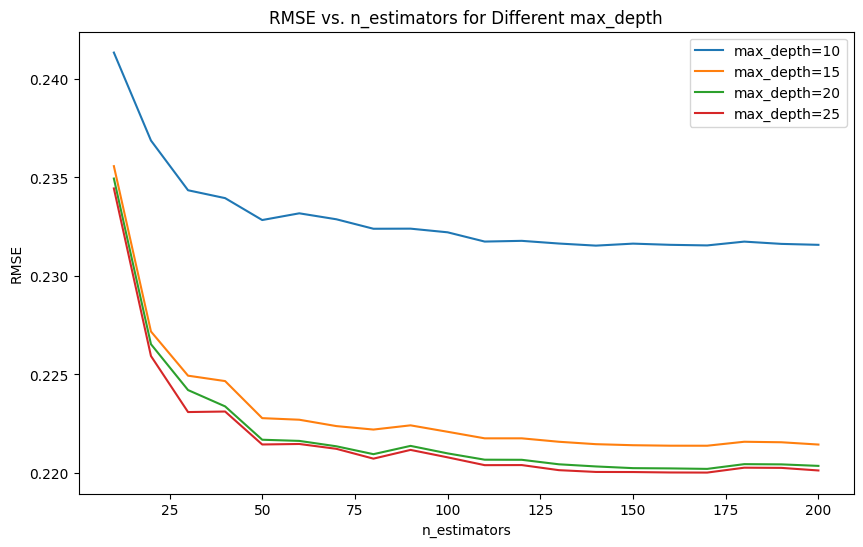

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the values to try for max_depth and n_estimators
max_depth_values = [10, 15, 20, 25]
n_estimators_range = list(range(10, 201, 10))

# Create a DataFrame to store RMSE values
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(columns=columns)

# Set a fixed random seed
random_state = 1

# Iterate through different max_depth values
for max_depth in max_depth_values:
    rmse_values = []
    for n_estimators in n_estimators_range:
        # Create and train the Random Forest model with the current max_depth and n_estimators values
        rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=-1)
        rfr.fit(X_train, y_train)
        
        # Make predictions on the validation data
        y_val_pred = rfr.predict(X_val)
        
        # Calculate the RMSE and append to the DataFrame
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_values.append(rmse)

    # Create a DataFrame for the current max_depth values
    df_subset = pd.DataFrame({'max_depth': [max_depth] * len(n_estimators_range),
                              'n_estimators': n_estimators_range,
                              'rmse': rmse_values})
    
    # Append the subset DataFrame to the main DataFrame
    df_scores = pd.concat([df_scores, df_subset], ignore_index=True)

# Visualize RMSE for different max_depth values
plt.figure(figsize=(10, 6))
for max_depth in max_depth_values:
    df_subset = df_scores[df_scores['max_depth'] == max_depth]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label=f'max_depth={max_depth}')

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. n_estimators for Different max_depth')
plt.legend()
plt.show()

In [34]:
pivoted_df = df_scores.pivot(index='n_estimators', columns='max_depth', values='rmse')
pivoted_df

max_depth,10,15,20,25
n_estimators,,,,
10,0.241337,0.235571,0.234941,0.234440
20,0.236872,0.227175,0.226531,0.225930
30,0.234346,0.224932,0.224202,0.223085
40,0.233947,0.224657,0.223373,0.223111
50,0.232834,0.222775,0.221679,0.221439
60,0.233175,0.222695,0.221620,0.221464
70,0.232873,0.222372,0.221347,0.221218
80,0.232392,0.222196,0.220946,0.220719
90,0.232397,0.222410,0.221367,0.221163


In [35]:
features = dv.get_feature_names_out()
list(features)

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [36]:
# Create and train the Random Forest model with the specified parameters
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

# Get the feature importances from the trained model
feature_importances = rfr.feature_importances_

# Create a mapping between feature names and their importances
feature_importance_mapping = dict(zip(list(features), feature_importances))

# Sort the dictionary by feature importance (values)
sorted_feature_importance_mapping = dict(sorted(feature_importance_mapping.items(), key=lambda item: item[1], reverse=True))

# Find the most important feature
most_important_feature = max(sorted_feature_importance_mapping, key=sorted_feature_importance_mapping.get)

print("The most important feature is:", most_important_feature)

The most important feature is: median_income


In [37]:
sorted_feature_importance_mapping

{'median_income': 0.3379279042710781,
 'ocean_proximity=INLAND': 0.24893893901401531,
 'ocean_proximity=<1H OCEAN': 0.1104838201350542,
 'latitude': 0.09656923490589613,
 'longitude': 0.08533583082197574,
 'housing_median_age': 0.032864341566613706,
 'population': 0.028045496144432795,
 'total_rooms': 0.0240657566201946,
 'households': 0.018602089082204197,
 'total_bedrooms': 0.01716658743853524}

In [38]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Create a watchlist for monitoring the validation performance
watchlist = [(dtrain, 'train'), (dval, 'validation')]

# Define xgboost parameters
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Define a list of eta values to try
etas = [0.3, 0.1]

# Lists to store evaluation results
evals_result = {}

best_eta = None
best_rmse = float('inf')

for eta in etas:
    xgb_params['eta'] = eta

    # Train the XGBoost model for 100 rounds
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=10
    )

    # Make predictions on the validation data
    y_pred = model.predict(dval)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f"eta={eta}, RMSE={rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_eta = eta

print(f"The best eta is {best_eta} with RMSE {best_rmse}")

[0]	train-rmse:0.44258	validation-rmse:0.44337
[10]	train-rmse:0.21631	validation-rmse:0.24122
[20]	train-rmse:0.18518	validation-rmse:0.22786
[30]	train-rmse:0.16752	validation-rmse:0.22248
[40]	train-rmse:0.15445	validation-rmse:0.21964
[50]	train-rmse:0.14353	validation-rmse:0.21757
[60]	train-rmse:0.13515	validation-rmse:0.21643
[70]	train-rmse:0.12718	validation-rmse:0.21515
[80]	train-rmse:0.11924	validation-rmse:0.21453


c:\users\konutech\ml-zoomcamp\machine-learning-zoomcamp\venv\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[90]	train-rmse:0.11412	validation-rmse:0.21439
[96]	train-rmse:0.11083	validation-rmse:0.21441
eta=0.3, RMSE=0.21440584842696978
[0]	train-rmse:0.52260	validation-rmse:0.52103
[10]	train-rmse:0.30297	validation-rmse:0.31080
[20]	train-rmse:0.24383	validation-rmse:0.26036
[30]	train-rmse:0.21940	validation-rmse:0.24255
[40]	train-rmse:0.20433	validation-rmse:0.23462
[50]	train-rmse:0.19516	validation-rmse:0.22955
[60]	train-rmse:0.18774	validation-rmse:0.22659
[70]	train-rmse:0.18168	validation-rmse:0.22439
[80]	train-rmse:0.17491	validation-rmse:0.22263
[90]	train-rmse:0.16932	validation-rmse:0.22056
[99]	train-rmse:0.16502	validation-rmse:0.21941
eta=0.1, RMSE=0.21940768718312995
The best eta is 0.3 with RMSE 0.21440584842696978


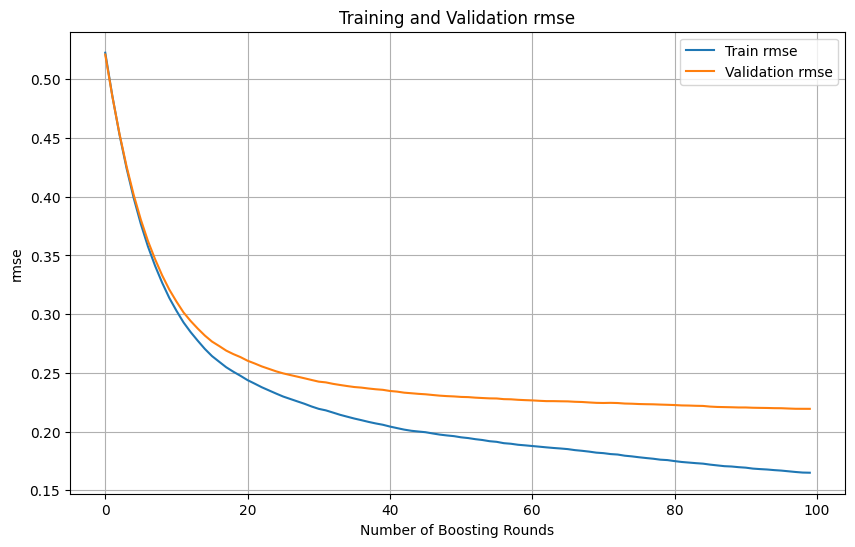

In [39]:
# Extract and plot evaluation results
train_metric = evals_result['train']['rmse']
validation_metric = evals_result['validation']['rmse']
plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train rmse')
plt.plot(validation_metric, label='Validation rmse')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('rmse')
plt.title('Training and Validation rmse')
plt.legend()
plt.grid()
plt.show()

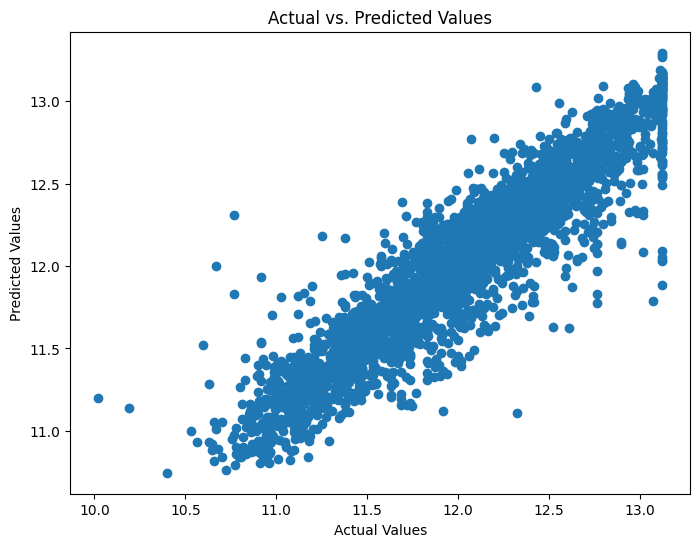

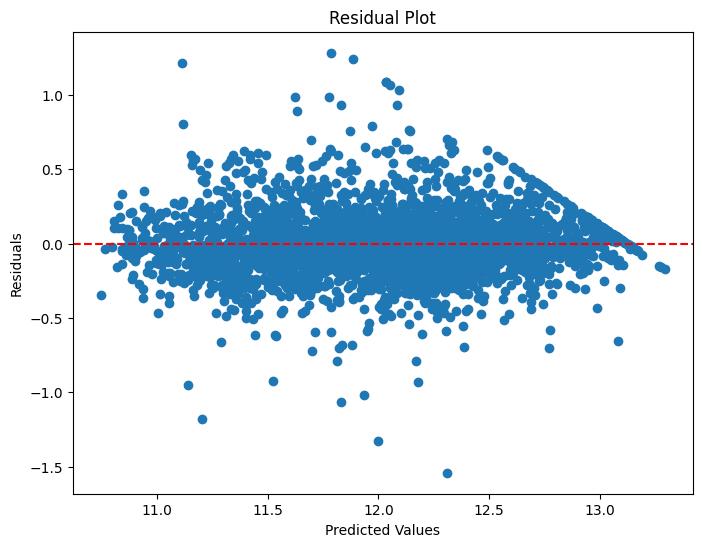

c:\users\konutech\ml-zoomcamp\machine-learning-zoomcamp\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\users\konutech\ml-zoomcamp\machine-learning-zoomcamp\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


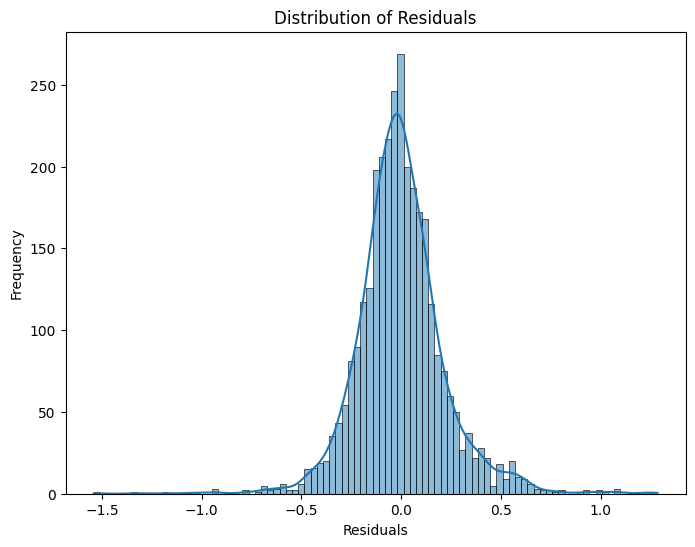

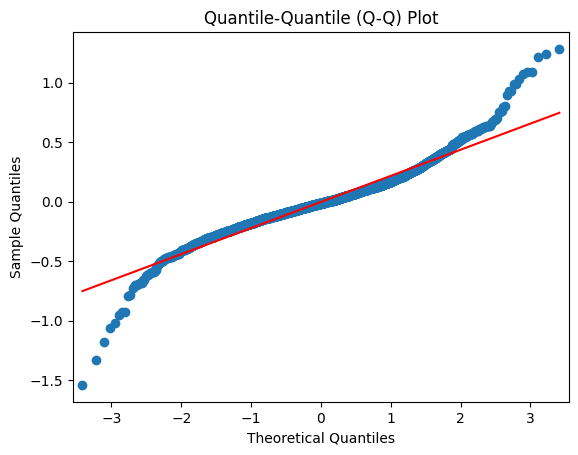

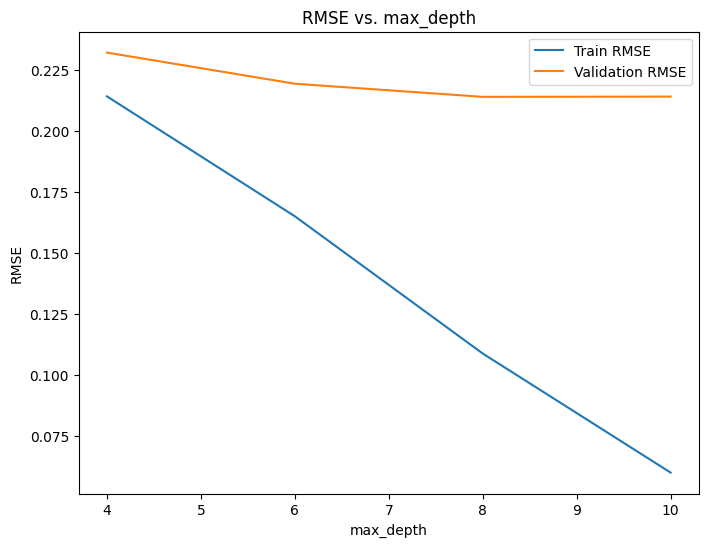

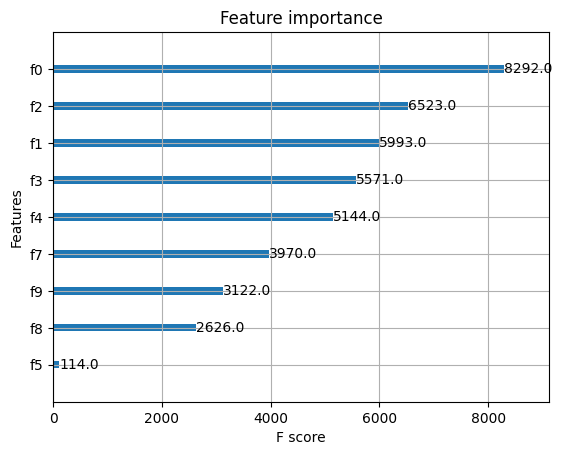

R-squared (R^2) Score: 0.847626994447825
Mean Squared Error (MSE): 0.0481397331950502
Root Mean Squared Error (RMSE): 0.21940768718312995
Mean Absolute Error (MAE): 0.15596573754570703


In [40]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming you've already trained an XGBoost regressor model

# Make predictions on the validation data
y_pred = model.predict(dval)

# Scatter Plot: Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residual Plot
residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Q-Q Plot
qq_plot = sm.qqplot(residuals, line='s')
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.show()

# Mean Squared Error (MSE) vs. Model Complexity
# Assuming you have a list of max_depth values to explore
max_depth_values = [4, 6, 8, 10]
train_errors, val_errors = [], []

for max_depth in max_depth_values:
    xgb_params['max_depth'] = max_depth
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)
    
    y_train_pred = model.predict(dtrain)
    y_val_pred = model.predict(dval)
    
    train_errors.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_errors.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))  # Corrected line

plt.figure(figsize=(8, 6))
plt.plot(max_depth_values, train_errors, label='Train RMSE')
plt.plot(max_depth_values, val_errors, label='Validation RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('RMSE vs. max_depth')
plt.legend()
plt.show()

# Feature Importance Plot
xgb.plot_importance(model)
plt.show()

# R-squared (R^2) Score
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R^2) Score: {r2}")

# Other Evaluation Metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
